In [17]:
# Penalize generative model if regression chooses expert input over linear input
# Compare to bootstrapping
# adding expert information decreases the amount of data necessary

# prior simulation



In [1]:
import sys
sys.argv = ['23']

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from matplotlib import pyplot as plt
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import config.config as cc
import itertools
import plotly.express as px 
from scipy import stats
from copy import deepcopy
from sklearn.model_selection import GroupShuffleSplit
from sklearn.datasets import fetch_openml
warnings.filterwarnings('ignore')

from _1_DataPrep import SpecificPrep
from Functions import metrics
from sklearn.datasets import fetch_openml
import pandas as pd
import joblib

%load_ext autoreload
%autoreload 2

Has EI


In [4]:
VARIABLES = ['VehPower',
 'VehAge',
 'DrivAge',
 'Density',
 'BonusMalus',
 'Exposure',
 'EI_Density',
 'EI_DrivAge',
 'EI_BonusMalus1',
 'EI_BonusMalus2',
 'EI_VehAge',
 'VehBrand',
 'VehGas',
 'Region',
 'Area',
 'ClaimNb']

In [5]:
specific_transformer = SpecificPrep(cc.metadata['cats_vars_gan'], cc.metadata['cats_vars_xgb'], addei=True, variables = VARIABLES)
train = pd.read_pickle(cc.train_common)
specific_transformer.fit(train)
train1 = specific_transformer.transform(train)
df1 = specific_transformer.inverse_transform(train1, keep_ei=True)


In [21]:
df1.head()

,ClaimNb,VehPower,VehAge,DrivAge,Density,BonusMalus,EI_Density,EI_DrivAge,EI_BonusMalus1,EI_BonusMalus2,...,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94,Area_2,Area_3,Area_4,Area_5,Area_6
0,1,5.00,0.00,55.00,7.10,50.00,0.06,0.06,0.05,0.17,...,True,False,False,False,False,False,False,True,False,False
1,1,5.00,0.00,55.00,7.10,50.00,0.06,0.06,0.05,0.17,...,True,False,False,False,False,False,False,True,False,False
3,1,7.00,0.00,46.00,4.33,50.00,0.05,0.05,0.05,0.17,...,False,False,False,False,False,True,False,False,False,False
4,1,7.00,0.00,46.00,4.33,50.00,0.05,0.05,0.05,0.17,...,False,False,False,False,False,True,False,False,False,False
11,1,7.00,0.00,56.00,5.15,50.00,0.05,0.06,0.05,0.17,...,False,False,False,True,False,False,True,False,False,False


In [ ]:
# TODO: Translate average frequencies into normalized coefficients (Check if this is already done)

Text(0, 0.5, 'Expert coefficients for vehicle age')

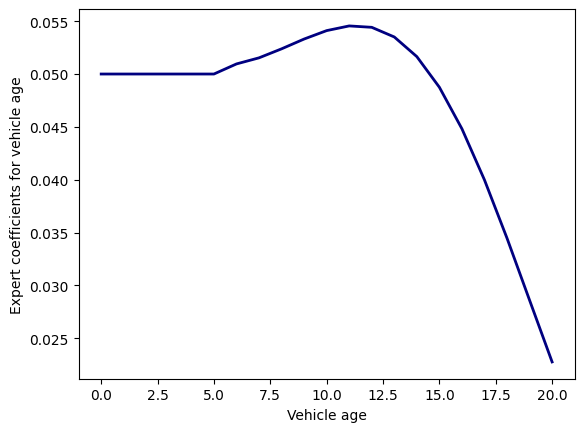

In [16]:
ax = df1.groupby('VehAge')['EI_VehAge'].mean().plot(
                                              lw=2, 
    colormap='jet', 
    marker='', 
    markersize=10, 
    title=''
                                              )
ax.set_xlabel("Vehicle age")
ax.set_ylabel("Expert coefficients for vehicle age")

In [ ]:
# Pert Distribution
# 

In [56]:
df1.groupby('BonusMalus')['EI_BonusMalus2'].mean().plot()

KeyError: 'Column not found: EI_BonusMalus2'

<Axes: xlabel='BonusMalus'>

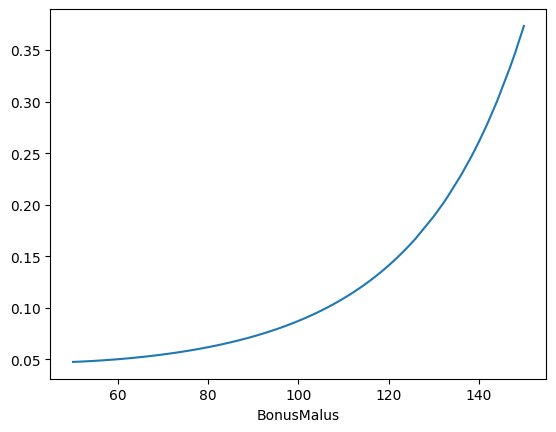

In [29]:
df1.groupby('BonusMalus')['EI_BonusMalus1'].mean().plot()

<Axes: xlabel='Density'>

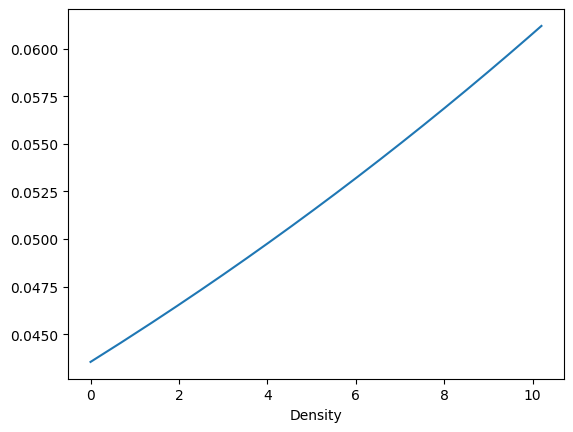

In [28]:
df1.groupby('Density')['EI_Density'].mean().plot()

<Axes: xlabel='DrivAge'>

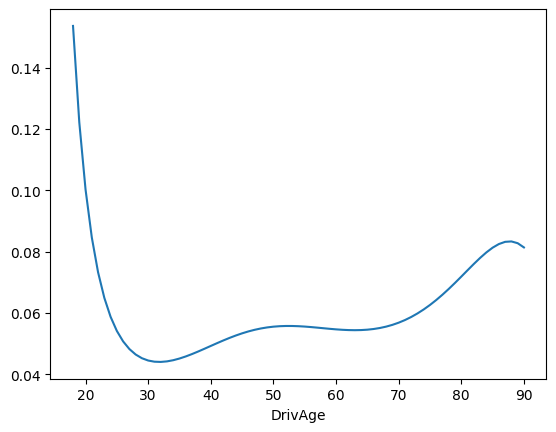

In [26]:
df1.groupby('DrivAge')['EI_DrivAge'].mean().plot()

In [ ]:
train = pd.read_pickle(cc.train_specific)
test = pd.read_pickle(cc.test_specific)

In [17]:
train['VehPowerGLM']


0         5
1         5
2         6
3         7
4         7
         ..
678008    4
678009    4
678010    6
678011    4
678012    7
Name: VehPowerGLM, Length: 541832, dtype: int64

In [18]:
# Expert input from Isabella
def build_predict(train, test, formula):
    glm1 = smf.glm(formula=formula, data=train, family=sm.families.Poisson(link=sm.families.links.log()), offset=np.log(train['Exposure'])).fit()
    preds_train = glm1.predict(train, offset=np.log(train['Exposure']))
    preds_test = glm1.predict(test, offset=np.log(test['Exposure']))
    
    return preds_train, preds_test

train['EI_Density'], test['EI_Density'] = build_predict(train, test, 'ClaimNb ~ Density') # GLM1, do not adjust

train['EI_DrivAge'], test['EI_DrivAge'] = build_predict(train, test, 'ClaimNb ~ DrivAge + I(DrivAge**2) + I(DrivAge**3) + I(DrivAge**4) + I(DrivAge**5)') # GLM5, do not adjust

train['EI_BonusMalus1'], test['EI_BonusMalus1'] = build_predict(train, test, 'ClaimNb ~ BonusMalus + I(BonusMalus**2)')

bm_below_100 = train.loc[train['BonusMalus'] <= 100, 'BonusMalus'].mean()
bm_above_100 = train.loc[train['BonusMalus'] > 100, 'BonusMalus'].mean()
train.loc[train['BonusMalus'] <= 100, 'EI_BonusMalus2'] = bm_below_100
test.loc[test['BonusMalus'] <= 100, 'EI_BonusMalus2'] = bm_below_100
train.loc[train['BonusMalus'] > 100, 'EI_BonusMalus2'] = bm_above_100
test.loc[test['BonusMalus'] > 100, 'EI_BonusMalus2'] = bm_above_100

train['EI_VehAge'], test['EI_VehAge'] = build_predict(train, test, 'ClaimNb ~ VehAge + I(VehAge**2) + I(VehAge**3)')

train.loc[train['VehAge'] <= 5, 'EI_VehAge'] = 0.05
test.loc[test['VehAge'] <= 5, 'EI_VehAge'] = 0.05



In [19]:
train.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,...,BonusMalusGLM,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,EI_Density,EI_DrivAge,EI_BonusMalus1,EI_BonusMalus2,EI_VehAge
0,1.0,1,0.10,D,5,0,55,50.0,B12,Regular,...,50,4,5,1,6,0.009941,0.009897,0.008153,59.079562,0.05
1,3.0,1,0.77,D,5,0,55,50.0,B12,Regular,...,50,4,5,1,6,0.076546,0.076210,0.062776,59.079562,0.05
2,5.0,1,0.75,B,6,2,52,50.0,B12,Diesel,...,50,2,6,2,6,0.072648,0.075692,0.061146,59.079562,0.05
3,10.0,1,0.09,B,7,0,46,50.0,B12,Diesel,...,50,2,7,1,5,0.008722,0.009081,0.007337,59.079562,0.05
4,11.0,1,0.84,B,7,0,46,50.0,B12,Diesel,...,50,2,7,1,5,0.081406,0.084755,0.068483,59.079562,0.05


In [20]:
train['ClaimNb'].describe()

count    541832.000000
mean          0.053242
std           0.238359
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: ClaimNb, dtype: float64

In [21]:
# Expert Input from GDV

# Vehicle Power
for df in train, test:
    df['GDV_Area'] = df['Area'].copy()
    df['GDV_Area'] = df['GDV_Area'].replace('A', 38.5)
    df['GDV_Area'] = df['GDV_Area'].replace('B', 41.5)
    df['GDV_Area'] = df['GDV_Area'].replace('C', 43.5)
    df['GDV_Area'] = df['GDV_Area'].replace('D', 46.5)
    df['GDV_Area'] = df['GDV_Area'].replace('E', (49+55)/2)
    df['GDV_Area'] = df['GDV_Area'].replace('F', (58+65)/2)

    # Vehicle Age
    df.loc[df['VehAge'] < 3, 'GDV_VehAge'] = 40
    df.loc[df['VehAge'] == 3, 'GDV_VehAge'] = 44
    df.loc[df['VehAge'].between(4, 5), 'GDV_VehAge'] = 46
    df.loc[df['VehAge'].between(6, 7), 'GDV_VehAge'] = 49
    df.loc[df['VehAge'] == 8, 'GDV_VehAge'] = 51
    df.loc[df['VehAge'] == 9, 'GDV_VehAge'] = 53
    df.loc[df['VehAge'].between(10, 11), 'GDV_VehAge'] = 57
    df.loc[df['VehAge'] == 12, 'GDV_VehAge'] = 61
    df.loc[df['VehAge'].between(13, 15), 'GDV_VehAge'] = 66
    df.loc[df['VehAge'].between(16, 17), 'GDV_VehAge'] = 69
    df.loc[df['VehAge'].between(18, 22), 'GDV_VehAge'] = 69
    df.loc[df['VehAge'] >= 23, 'GDV_VehAge'] = 34

    # Driver Age
    df.loc[df['DrivAge'] <= 18, 'GDV_DrivAge'] = 97
    df.loc[df['DrivAge'] == 19, 'GDV_DrivAge'] = 84
    df.loc[df['DrivAge'] == 20, 'GDV_DrivAge'] = 75
    df.loc[df['DrivAge'].between(21, 22), 'GDV_DrivAge'] = 67
    df.loc[df['DrivAge'].between(23, 24), 'GDV_DrivAge'] = 59
    df.loc[df['DrivAge'].between(25, 26), 'GDV_DrivAge'] = 67
    df.loc[df['DrivAge'].between(27, 41), 'GDV_DrivAge'] = 47
    df.loc[df['DrivAge'].between(42, 62), 'GDV_DrivAge'] = 37
    df.loc[df['DrivAge'].between(63, 67), 'GDV_DrivAge'] = 37
    df.loc[df['DrivAge'].between(68, 70), 'GDV_DrivAge'] = 40
    df.loc[df['DrivAge'].between(71, 72), 'GDV_DrivAge'] = 44
    df.loc[df['DrivAge'].between(73, 74), 'GDV_DrivAge'] = 48
    df.loc[df['DrivAge'].between(75, 76), 'GDV_DrivAge'] = 54
    df.loc[df['DrivAge'].between(77, 78), 'GDV_DrivAge'] = 58
    df.loc[df['DrivAge'].between(79, 81), 'GDV_DrivAge'] = 63
    df.loc[df['DrivAge'] >= 82, 'GDV_DrivAge'] = 74

In [22]:
train.to_pickle('./data/common_dataprep/train_with_ei.pickle')
test.to_pickle('./data/common_dataprep/test_with_ei.pickle')